# MQ-7

## Acetone

### Specifications

#### Standard Work Condition

    Vc    (Circuit Voltage)        :  5v +/- 0.1
    VH(h) (Heating Voltage - high) :  5v +/- 0.1
    VH(l) (Heating Voltage - low)  :  1.4v +/- 0.1
    RL    (Load Resistance)        :  can adjust
    RH    (Heater Resistance)      :  33 Ohm +/- 5%
    TH(H) (Heating time (high)     :  60 +/- 1 seconds
    TH(L) (Heating time (low)      :  90 +/- 1 seconds
    PH    (Heating consumption)    :  about 350 mW
    

#### Sensitivity Characteristic:

    Rs (Sensing Resistance)    : 2kOhm  -  20kOhm (100ppm Carbon Monoxide)
    Preheat Time               : No less than 48 hours
    
    Detecting range:
        Carbon Monoxide:  20ppm  - 2000ppm 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
## Gas concentration values referenced in the datasheet
POINTS = {
     # Carbon Monoxide
    'co' : {
        'p1' : {'x': 50,   'y':1.605},
        'p2' : {'x': 100,  'y':1.000},
        'p3' : {'x': 400,  'y':0.381},
        'p4' : {'x': 1000, 'y':0.217},
        'p5' : {'x': 4000, 'y':0.090}
    },

    # Hydrogen
    'h2' : {
        'p1' : {'x': 50,   'y':1.278},
        'p2' : {'x': 100,  'y':0.792},
        'p3' : {'x': 400,  'y':0.276},
        'p4' : {'x': 1000, 'y':0.141},
        'p5' : {'x': 4000, 'y':0.052}
    },

    # Liquefied Petroleum Gas
    'lpg' : {
        'p1' : {'x': 50,   'y':9.005},
        'p2' : {'x': 100,  'y':7.989},
        'p3' : {'x': 400,  'y':6.675},
        'p4' : {'x': 1000, 'y':5.993},
        'p5' : {'x': 4000, 'y':4.948}
    },

    # Methane
    'ch4' : {
        'p1' : {'x': 50,   'y':13.859},
        'p2' : {'x': 100,  'y':12.745},
        'p3' : {'x': 400,  'y':11.720},
        'p4' : {'x': 1000, 'y':11.039},
        'p5' : {'x': 4000, 'y':9.005}
    },

    'alcohol' : {
        'p1' : {'x': 50,   'y':16.194},
        'p2' : {'x': 100,  'y':14.715},
        'p3' : {'x': 400,  'y':13.054},
        'p4' : {'x': 1000, 'y':12.745},
        'p5' : {'x': 4000, 'y':12.004}
    },    
}


AIR = 25.836

GASES = ['co', 'h2', 'lpg', 'ch4', 'alcohol']

In [3]:
# RS value calculation
Rs    = lambda Vcc, Vrl, RL : ((Vcc * RL) / Vrl) - RL

# R0 value calculation
R0    = lambda Rs, air : Rs / air

# RS/Ro value calculation (ratio)
Ratio = lambda Rs, R0: Rs / R0

# log(y) = m.log(x) + b
# m
M     = lambda p1, p2 : (math.log10( p2['y'] / p1['y'] )) / (math.log10(p2['x']/p1['x']))
# b
B     = lambda p, m : math.log10(p['y']) - (m * math.log10(p['x']))

# PPM value calculation 
PPM   = lambda  y, m, b: 10 ** ((math.log10(y) - b) / m)

In [4]:
## Calculate the points to be used for the calculation of _m_ and _b_ according to the _ratio_ value 
def getPoints(racio, values):
    size = len(values)
    for idx in range(size - 1):
        if racio >= values[idx]['y']:
            if idx == 0:
                return (values[0], values[1])
            return(values[idx - 1], values[idx])
    return(values[size - 2], values[size - 1])

In [5]:
pList = {}
for gas in GASES:
    pList[gas] = list(POINTS[gas].values())

In [6]:
df = pd.read_csv('acetone_mq7-9.csv')

mq7_1 = pd.DataFrame({'volt': df["sensor1"]})
mq7_2 = pd.DataFrame({'volt': df["sensor2"]})
mq7_3 = pd.DataFrame({'volt': df["sensor3"]})

### Ro values to be considered

- __Sensor 1__: 7.66 kOhms
- __Sensor 2__: 16.5 kOhms 
- __Sensor 3__: 10.82 kOhms 

In [7]:
# MQ 7 - sensor 1
sensor1 = {}
sensor1['Vcc'] = 5      #volts
sensor1['RL']  = 10     #kOhms
sensor1['AIR'] = AIR   
sensor1['Ro']  = 7.66   #kOhms

# MQ 7 - sensor 2
sensor2 = {}
sensor2['Vcc'] = 5      #volts
sensor2['RL']  = 10     #kOhms
sensor2['AIR'] = AIR   
sensor2['Ro']  = 16.5   #kOhms

# MQ 7 - sensor 3
sensor3 = {}
sensor3['Vcc'] = 5      #volts
sensor3['RL']  = 10     #kOhms
sensor3['AIR'] = AIR   
sensor3['Ro']  = 10.82   #kOhms

In [8]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max

Vrl = [
    mq7_1['volt'].min(),
    mq7_1['volt'].mean(), 
    mq7_1['volt'].quantile(0.25),
    mq7_1['volt'].quantile(0.5),
    mq7_1['volt'].quantile(0.75),
    mq7_1['volt'].max()]

sensor1['Rs'] = [Rs(sensor1['Vcc'] , v, sensor1['RL'] ) for v in Vrl]
sensor1['Ratio'] = [Ratio(rs, sensor1['Ro']) for rs in sensor1['Rs']]

ppm1 = {}
for gas in GASES:
    ppm1[gas] = []

for r in sensor1['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm1[gas].append(PPM(r, m, b))

In [9]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max

Vrl = [
    mq7_2['volt'].min(),
    mq7_2['volt'].mean(), 
    mq7_2['volt'].quantile(0.25),
    mq7_2['volt'].quantile(0.5),
    mq7_2['volt'].quantile(0.75),
    mq7_2['volt'].max()]

sensor2['Rs'] = [Rs(sensor2['Vcc'] , v, sensor2['RL'] ) for v in Vrl]
sensor2['Ratio'] = [Ratio(rs, sensor2['Ro']) for rs in sensor2['Rs']]

ppm2 = {}
for gas in GASES:
    ppm2[gas] = []

for r in sensor2['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm2[gas].append(PPM(r, m, b))

In [10]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max

Vrl = [
    mq7_3['volt'].min(),
    mq7_3['volt'].mean(), 
    mq7_3['volt'].quantile(0.25),
    mq7_3['volt'].quantile(0.5),
    mq7_3['volt'].quantile(0.75),
    mq7_3['volt'].max()]

sensor3['Rs'] = [Rs(sensor3['Vcc'] , v, sensor3['RL'] ) for v in Vrl]
sensor3['Ratio'] = [Ratio(rs, sensor3['Ro']) for rs in sensor3['Rs']]

ppm3 = {}
for gas in GASES:
    ppm3[gas] = []

for r in sensor3['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm3[gas].append(PPM(r, m, b))

In [11]:
def printMM3QM(name, sensor, ppm):
    print(name)

    print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
           .format('', 'Min', 'Mean', '1Q', '2Q', '3Q', 'Max'))

    print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
           .format('Rs/Ro', 
                   round(sensor['Ratio'][0],3),
                   round(sensor['Ratio'][1],3),
                   round(sensor['Ratio'][2],3),
                   round(sensor['Ratio'][3],3),
                   round(sensor['Ratio'][4],3),
                   round(sensor['Ratio'][5],3)))

    for gas in GASES:
        print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
               .format(gas.upper(), 
                       round(ppm[gas][0],3),
                       round(ppm[gas][1],3),
                       round(ppm[gas][2],3),
                       round(ppm[gas][3],3),
                       round(ppm[gas][4],3),
                       round(ppm[gas][5],3)))

In [12]:
printMM3QM("Sensor1", sensor1, ppm1)

print("-"*(12*7))

printMM3QM("Sensor2", sensor2, ppm2)

print("-"*(12*7))

printMM3QM("Sensor3", sensor3, ppm3)

print("-"*(12*7))

Sensor1
             Min          Mean         1Q           2Q           3Q           Max         
Rs/Ro        27.075       23.775       27.075       25.892       20.453       16.336      
CO           0.797        0.964        0.797        0.85         1.201        1.67        
H2           0.6          0.724        0.6          0.64         0.901        1.247       
LPG          0.085        0.181        0.085        0.11         0.433        1.59        
CH4          0.196        0.576        0.196        0.284        1.999        12.829      
ALCOHOL      1.212        3.105        1.212        1.675        9.229        46.935      
------------------------------------------------------------------------------------
Sensor2
             Min          Mean         1Q           2Q           3Q           Max         
Rs/Ro        29.697       20.366       26.942       24.646       17.219       10.216      
CO           0.696        1.209        0.802        0.914        1.546        3.

In [13]:
font = {
    'family': 'serif',
    'color':  'tab:red',
    'weight': 'normal',
    'size': 14
}

font_title = {
    'family': 'serif',
    'color':  'tab:blue',
    'weight': 'normal',
    'size': 16,
}

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray','tab:olive','tab:cyan']

In [14]:
# Sensor 1

sensor1['Rs'] = [Rs(sensor1['Vcc'] , v, sensor1['RL'] ) for v in mq7_1["volt"]]
sensor1['Ratio'] = [Ratio(rs, sensor1['Ro']) for rs in sensor1['Rs']]

ppm1 = {}
for gas in GASES:
    ppm1[gas] = []
    
for r in sensor1['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm1[gas].append(PPM(r, m, b)) 

for gas in GASES:       
    mq7_1[gas] = [ round(val, 3) for val in ppm1[gas]]

print(mq7_1.head())

   volt     co    h2    lpg    ch4  alcohol
0  0.24  0.850  0.64  0.110  0.284    1.675
1  0.23  0.797  0.60  0.085  0.196    1.212
2  0.24  0.850  0.64  0.110  0.284    1.675
3  0.23  0.797  0.60  0.085  0.196    1.212
4  0.24  0.850  0.64  0.110  0.284    1.675


In [15]:
# Sensor 2

sensor2['Rs'] = [Rs(sensor2['Vcc'] , v, sensor2['RL'] ) for v in mq7_2["volt"]]
sensor2['Ratio'] = [Ratio(rs, sensor2['Ro']) for rs in sensor2['Rs']]

ppm2 = {}
for gas in GASES:
    ppm2[gas] = []
    
for r in sensor2['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm2[gas].append(PPM(r, m, b)) 

for gas in GASES:       
    mq7_2[gas] = [ round(val, 3) for val in ppm2[gas]]

print(mq7_2.head())

   volt     co     h2    lpg    ch4  alcohol
0  0.11  0.802  0.604  0.088  0.205    1.256
1  0.11  0.802  0.604  0.088  0.205    1.256
2  0.12  0.914  0.687  0.147  0.427    2.393
3  0.11  0.802  0.604  0.088  0.205    1.256
4  0.11  0.802  0.604  0.088  0.205    1.256


In [16]:
# Sensor 3

sensor3['Rs'] = [Rs(sensor3['Vcc'] , v, sensor3['RL'] ) for v in mq7_3["volt"]]
sensor3['Ratio'] = [Ratio(rs, sensor3['Ro']) for rs in sensor3['Rs']]

ppm3 = {}
for gas in GASES:
    ppm3[gas] = []
    
for r in sensor3['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm3[gas].append(PPM(r, m, b)) 

for gas in GASES:       
    mq7_3[gas] = [ round(val, 3) for val in ppm3[gas]]

print(mq7_3.head())

   volt     co     h2    lpg    ch4  alcohol
0  0.17  0.833  0.627  0.102  0.253    1.513
1  0.17  0.833  0.627  0.102  0.253    1.513
2  0.17  0.833  0.627  0.102  0.253    1.513
3  0.17  0.833  0.627  0.102  0.253    1.513
4  0.17  0.833  0.627  0.102  0.253    1.513


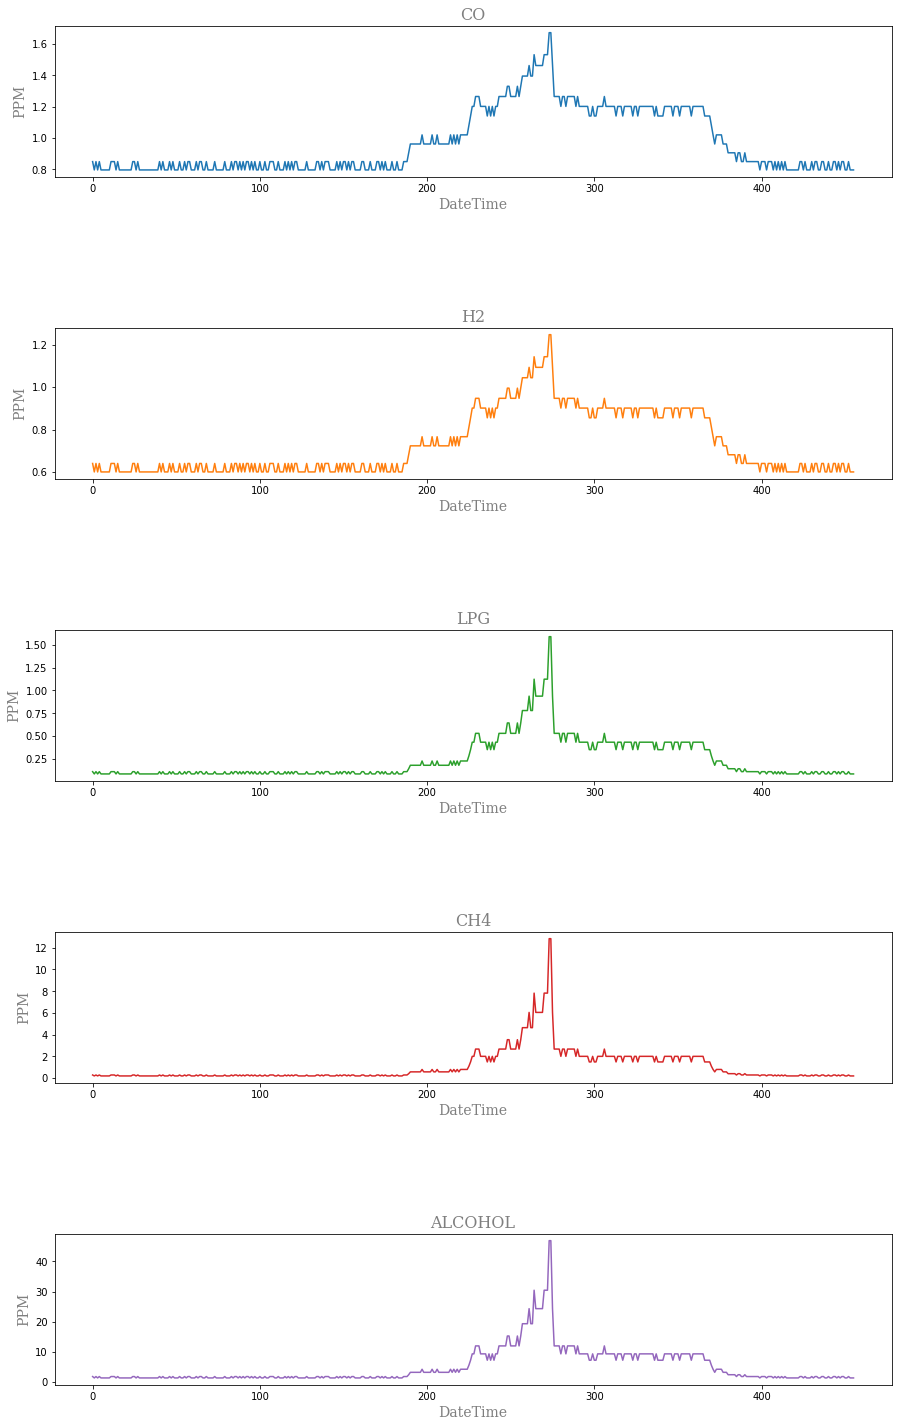

In [17]:
# Sensor 1
plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace = 1)

for idx in range(len(GASES)):
    plt.subplot(len(GASES) * 100 + 11 + idx)
    plt.plot(mq7_1[GASES[idx]],                            color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    
plt.show()

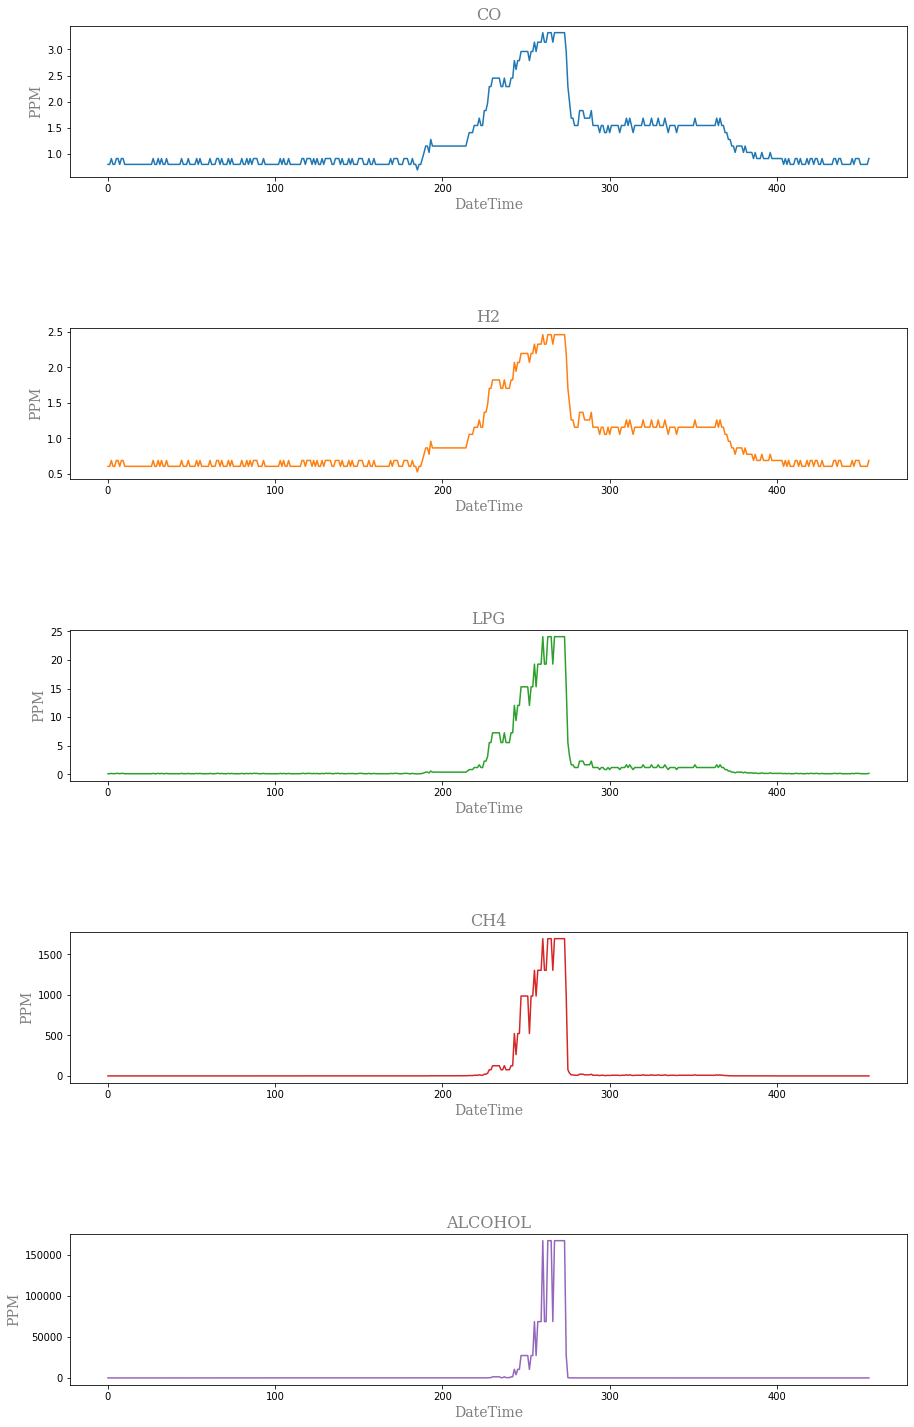

In [18]:
# Sensor 2
plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace = 1)

for idx in range(len(GASES)):
    plt.subplot(len(GASES) * 100 + 11 + idx)
    plt.plot(mq7_2[GASES[idx]],                            color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    
plt.show()

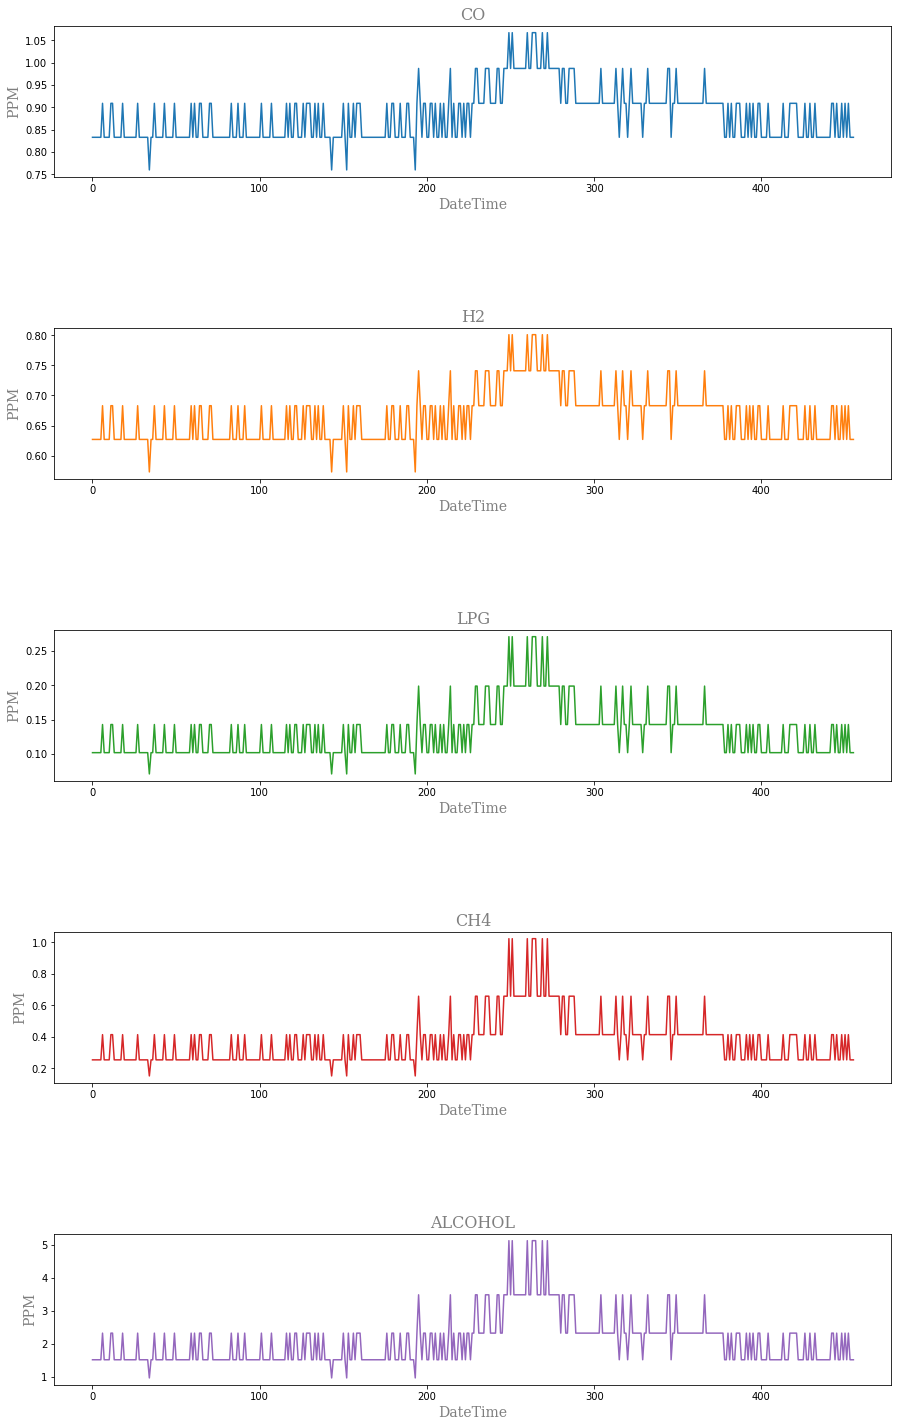

In [19]:
# Sensor 3
plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace = 1)

for idx in range(len(GASES)):
    plt.subplot(len(GASES) * 100 + 11 + idx)
    plt.plot(mq7_3[GASES[idx]],                            color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    
plt.show()

In [20]:
# Save in csv file
mq7_1.to_csv('mq7_1.csv')
mq7_2.to_csv('mq7_2.csv')
mq7_3.to_csv('mq7_3.csv')